In [219]:
%display None


In [220]:
from itertools import product
from itertools import combinations
from itertools import permutations
from collections import defaultdict
import time
import sage.graphs.graph_plot
from sage.plot.graphics import GraphicsArray
import numpy as np
from sage.combinat.q_analogues import q_factorial

In [224]:
n = 3
q = 2
#FF = GF(9,'c')
FF = GF(q)
so = FF.cardinality()^n-1
thm = (FF.cardinality()^n-1)^(n-1)
mult = (q-1)^(n-1)*(add([q^i for i in range(n)])^(n-2))
G = GL(n, FF)
M = MatrixSpace(FF,n,n)
V = VectorSpace(FF,n)
fact = (q^n-1)^(n-1)
nq=gaussian_binomial(n,1,q=q)
num_valid_hyp = q^(binomial(n,2))*q_factorial(n,q)

def get_hyperplanes(): #generate all hyperplanes of gl(n,q)
    H = []
    for i in range(n):
        h = matrix(FF,n-1,n)
        for j in range(n):
            if j<i:
                h[j,j] = 1
            if j>i:
                h[j-1,j] = 1
        if i >0:
            comblist = [p for p in product(GF(q), repeat=i)]
            num = len(comblist)
            for k in range(num):
                b = h
                v = comblist[k]
                for l in range(i):
                    b[l,i] = v[l]
                H.append(copy(b))
        else: H.append(h)
    return H

def is_reflection(g):
    n = G.degree()
    M = g.matrix() - (G[0]**0).matrix()
    KM = M.kernel()
    return KM.dimension() == n-1

def find_hyperplane(g):
    M = g.matrix() - (G[0]**0)
    m = kernel(M)
    return m

def valid_hyps(n,q):
    valid_hyps = []
    H = get_hyperplanes()
    for h_s in combinations(H,n):
        prev = h_s[0]
        for i in range(n-1):
            sub = V.subspace(h_s[i+1]).intersection(V.subspace(prev))
            prev = sub
        if sub.dimension() == 0:
            valid_hyps.append(h_s)
    return valid_hyps

def is_transvection(g):
    return is_reflection(g) and M(g).determinant() == 1


def get_transvections():
    R = []
    for g in G:
        if is_transvection(g):
            R.append(g)
    return R

def get_refls():
    R = []
    for g in G:
        if is_reflection(g):
            R.append(g)
    return R

def get_singer(): #find all singer cycles in a list
    S = []
    for g in G:
        if g.multiplicative_order() == so:
            S.append(g)
    return S

def get_one_singer(): #find all singer cycles in a list
    for g in G:
        if g.multiplicative_order() == so:
            break
    return g

def get_reg_ells():
    S = []
    #D = defaultdict(int)
    #D2 = defaultdict(tuple)
    for g in G:
        A = M(g)
        cp = A.charpoly()
        if cp.is_irreducible():
            #D[cp] += 1
            #D2[cp] += (g,)
            S.append(g)
    return S

def sing_with_det(alp):
    c1=[]
    for c in L:
        if c.matrix().determinant() == alp:
            c1.append(c)
    return c1

def insert_row(M,k,row):
    return matrix(FF,M.rows()[:k]+[row]+M.rows()[k:])

def get_reg_ells():
    S = []
    D = defaultdict(int)
    D2 = defaultdict(tuple)
    for g in G:
        A = M(g)
        cp = A.charpoly()
        if cp.is_irreducible():
            D[cp] += 1
            D2[cp] += (g,)
            S.append(g)
    return S, D, D2
def get_fact(R,c):
    F = []
    for i in product(range(len(R)),repeat = G.degree()):
        if mul([R[i[k]] for k in range(G.degree())]) == c:
            F.append([R[i[k]] for k in range(G.degree())])
    return F

def get_fact_faster(R,c):
    F = []
    for i in product(range(len(R)),repeat = G.degree()-1):
        m = c*mul([R[i[k]] for k in range(G.degree()-1)]).inverse()
        if is_reflection(m):
            F.append([R[i[k]] for k in range(G.degree()-1)] + [m,])
    return F

#generate 1-dim vectors
def get_v1():
    H=get_hyperplanes()
    vec=[]
    for h in H:
        m=transpose(matrix(FF,h))
        v=kernel(m)
        vec.append(v)
    return vec

vec=get_v1()
#newvec=[vec[3],vec[1],vec[4],vec[0],vec[-2],vec[2],vec[-1]]
newvec=vec

label = []
for v in newvec:
    v1=v.basis()
    label.append(v1)
vertex={}
for v in range(nq):
    vertex[v]=str(label[v][0])

In [225]:
len(R)

21

In [226]:
#Set up
R = get_refls()
H=get_hyperplanes()
#S = get_singer()
c = get_one_singer()

In [202]:
hyp_of_ref = {}
for r in R:
    hyp_of_ref[r] = find_hyperplane(r)

all_refls_with_hyp = {}
for h in H:
    refl = [k for k, v in hyp_of_ref.items() if v == V.subspace(h)]
    all_refls_with_hyp[H.index(h)] = refl

In [203]:
all_valid_hyps = valid_hyps(n,q)

In [205]:
len(all_valid_hyps)

840

In [173]:
valid_H_standard(n,q)

[
[0 1 0]  [1 0 0]  [1 0 0]
[0 0 1], [0 0 1], [0 1 0]
]

In [193]:
fact_w_fixed_hs = []
ind_0 = [H.index(h) for h in valid_H_standard(n,q)]
for ind in permutations(ind_0):
    r1 = all_refls_with_hyp[ind[0]]
    r2 = all_refls_with_hyp[ind[1]]
    r3 = all_refls_with_hyp[ind[2]]
    for test in product(r1,r2,r3):
        if matrix(FF,prod(test)) == S[2]:
                fact_w_fixed_hs.append(test)



In [195]:
fact_w_fixed_hs

[(
[1 1 0]  [1 0 0]  [1 0 0]
[0 1 0]  [0 1 0]  [0 1 1]
[0 0 1], [1 1 1], [0 0 1]
),
 (
[1 0 0]  [1 0 0]  [1 1 1]
[1 1 1]  [0 1 0]  [0 1 0]
[0 0 1], [1 0 1], [0 0 1]
),
 (
[1 0 0]  [1 1 0]  [1 0 0]
[0 1 0]  [0 1 0]  [0 1 1]
[1 0 1], [0 0 1], [0 0 1]
),
 (
[1 0 0]  [1 0 0]  [1 1 1]
[0 1 0]  [0 1 1]  [0 1 0]
[1 0 1], [0 0 1], [0 0 1]
)]

In [190]:
def get_fact_even_faster(c):
    fact = []
    for h_s in all_valid_hyps:
        ind_0 = [H.index(h) for h in h_s]
        for ind in permutations(ind_0):
            r1 = all_refls_with_hyp[ind[0]]
            r2 = all_refls_with_hyp[ind[1]]
            r3 = all_refls_with_hyp[ind[2]]
            for test in product(r1,r2,r3):
                if matrix(FF,prod(test)) == c:
                    fact.append(test)
                    #print(ind)
    return fact


In [191]:
facts_of_c = get_fact_even_faster(S[2])

In [ ]:
#Try to generalize this 
fact = []
for h_s in all_valid_hyps:
    ind_0 = [H.index(h) for h in h_s]
    for ind in permutations(ind_0):
        refls = {}
        for i in range(n):
            refls[f"r{i+1}"] = all_refls_with_hyp[ind[i]]
        for test in product(refls['r1'],r2,r3,r4):
            if matrix(FF,prod(test)) == S[0]:
                fact.append(test)
    print(all_valid_hyps.index(h_s))
len(fact)

In [102]:
len(all_valid_hyps)*factorial(n) == num_valid_hyp

True

In [104]:
len(R)^4

121550625

In [199]:
len(all_valid_hyps)

28

In [107]:
(len(all_refls_with_hyp[0])^4) * num_valid_hyp

48404160

In [80]:
#Brute force calculation to obtain all factorization for a FIXED singer cycle c
#kind of slow, even for q=1
c=S[0]
#get_fact(R,S[0])

Another way to study the case of GL(n,q) is to study the factorization of singer cycles of the same conjugacy class. For a fixed conjugacy class of a Singer cycle, we fix a sequence of valid hyperplanes (the sequence of hyperplanes that are linearly independent and also span the entire space). The easist set up is let such $H_1$, $H_2$, and $H_3$ be $H_i = \mathrm{span}(\hat{e}_i)$. Then it is very easy to generate all reflections that fixes $H_i$ because we just need to compute one row. Then the number of brute force calculation we need to go through to generate all factorizations reduces significantly.

In [6]:
#Building the sequence of standard valid H's
def valid_H_standard(n,q):
    FF = GF(q)
    V = VectorSpace(FF,n)
    valid_H = []
    for i in range(n):
        e_s= [e for e in V.basis()]
        del e_s[i]
        valid_H.append(matrix(FF, e_s))
    return valid_H


In [7]:
#Build all refelction elements
#input the sequence of desired determinants - for q=2 case, it's just 1's.
#Outputs a list of reflection sequences with chosen determinants
#Note that these are just all possible reflection combos given the desired determinant sequence 
#- still need to test if it is a factorization
def invertible_vi(n,q,dlist):
    FF = GF(q)
    #First build all possible vectors, in a form of a single matrix
    Vm =[]
    comblist = list(product(list(product(GF(q), repeat = n-1)), repeat = n))
    for comb in comblist:
        m = matrix(FF,n)
        for i in range(n):
            v = list(comb[i])
            v.insert(i,dlist[i])
            m[i] = v
        Vm.append(m)

    #Then inserting these rows into the hyperplanes to build the reflection sequences
    Hlist = valid_H_standard(n,q)
    allv = []
    for v_s in Vm:
        Rlist = []
        for i in range(n):
            v=vector(v_s[i,:])
            tab = insert_row(Hlist[i],i,v)
            ref = matrix(FF, tab)
            Rlist.append(ref)
        allv.append(Rlist)
    return allv

#Now testing each of those reflection sequences to see if it is indeed a factorization
#Insert n,q, dets, Singer

def get_fact_conj(n,q, dlist,c):
    fact = []
    allv = invertible_vi(n,q,dlist)
    for r in allv:
        test = prod(r)
        f_test= matrix(test).charpoly()
        c_conj= matrix(c).charpoly()
        if f_test == c_conj:
            fact.append(r)
    return fact


In [8]:
#Choose a Singer cycle and check its conjugacy class
c = S[0]
matrix(c).charpoly()

x^4 + x + 1

In [9]:
#Get all factorizations of the kinds with the standard valid hyperplanes of such conjugacy class
#For q=2, our determinants will always just be 1's
dlist = [1]*n
fact_fixed_conj = get_fact_conj(n,q,dlist,c)

In [10]:
#fun fact + sanity check, this should be (q-1)^(n-1)x[n]^(n-2)
len(fact_fixed_conj) == nq^(n-2)

True

In [11]:
conju=[]
for c in S:
    f=matrix(c).charpoly()
    if f not in conju:
        conju.append(f)
conju

[x^4 + x + 1, x^4 + x^3 + 1]

In [216]:
d=[1,2,3]


In [218]:
f = open("demofile3.txt", "w")
f.write(str(d))
f.close()

In [213]:
f = open("demofile3.txt", "w")
print(f.read())

UnsupportedOperation: not readable

Building the graph out of these factorizations

In [227]:


def get_edge(r):
    edge=[]
    for v in newvec:
            w = v*r
            if v!=w:
                edge.append([newvec.index(v),newvec.index(w)])
    return edge

#input a factorzation [r1,r2,r3]
def get_edges(rrr):
    edges=[]
    for i in range(n):
        edge=get_edge(rrr[i])
        edges.append(edge)
    return edges

#n_q x n_q matrix, put 1 for each edge correspondnce to build the adjacency matrix for each r_i
def adj_matrix(edge):
    M=matrix(nq)
    for e in edge:
        M[e[0],e[1]]=1
    return M

def get_adj_matrix(rrr):
    edges=get_edges(rrr)
    Mlist=[]
    for i in range(n):
        M2=matrix(nq)
        for e in edges[i]:
            M2[e[0],e[1]]=1
        Mlist.append(M2)
    return Mlist

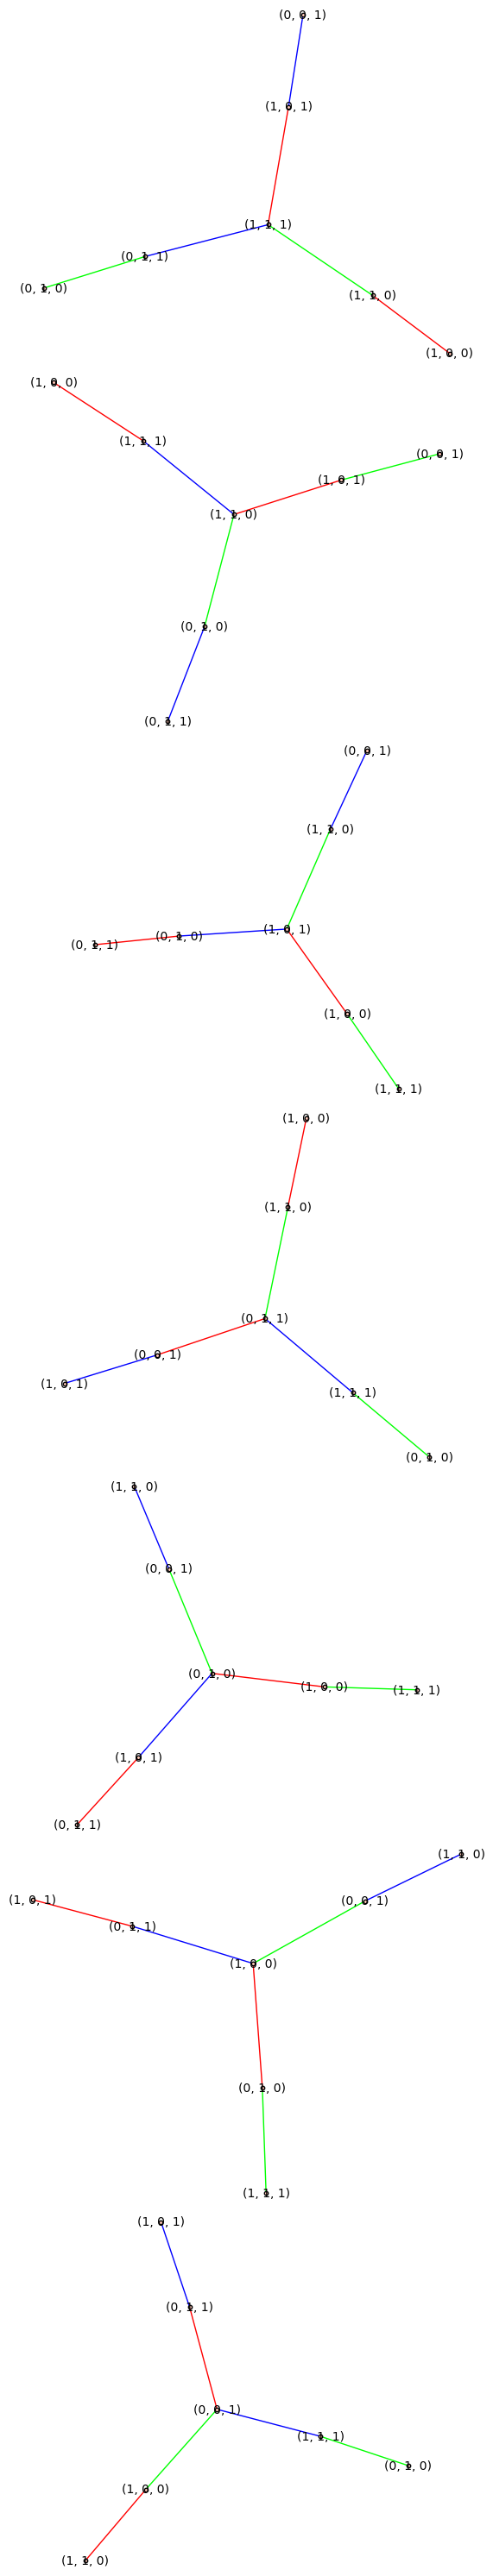

In [228]:
#Play around with the vertex labeling. It can get pretty crazy as n grows.
graphs_ = []
for j,r_s in enumerate(facts_of_c):
    Mlist = get_adj_matrix(r_s)
    #[M1,M2,M3]=get_adj_matrix(rrr[0])
    Dlist= [DiGraph(adj_m) for adj_m in Mlist]
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()

    seed = [v for v in G if G.degree(v) == n]
    for v in seed:
        if all(G.degree(w) == n-1 for w in G.neighbors(v)) == True:
             graphs_.append([G.plot(color_by_label=True,vertex_size=10,layout='spring',vertex_labels=True)])
    # seed = [v for v in G if G.degree(v) == n]
    # for v in seed:
    #     print(G.neighbors(v))




grid = GraphicsArray(graphs_)
grid.show(figsize=40)
#grid.save('tree_2_2.png',figsize=50)



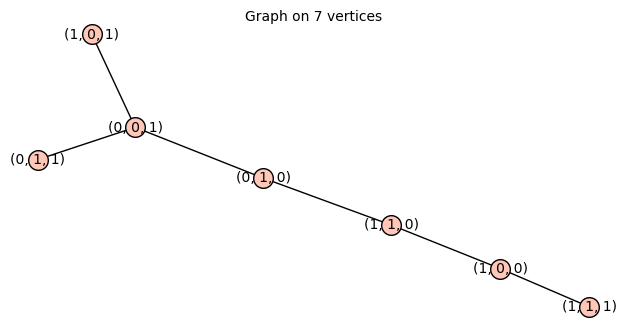

In [230]:
for G

In [79]:
i=0
for neighbors in seed_neighbors:
    if neighbors[0] == seed_neighbors[80][0]:
        i = i+1
        print(neighbors)
i

[['(1, 0, 1, 1)'], ['(0, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(0, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(0, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(0, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(0, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 1, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 1, 1)'], ['(1, 1, 1, 0)']]
[

34

In [65]:
seed_neighbors = []
for j,r_s in enumerate(fact_fixed_conj):
    Mlist = get_adj_matrix(r_s)
    #[M1,M2,M3]=get_adj_matrix(rrr[0])
    Dlist= [DiGraph(adj_m) for adj_m in Mlist]
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()

    # seed = [v for v in G if G.degree(v) == n]
    # for v in seed:
    seed_neighbors.append([G.neighbors(vertex[0]), G.neighbors(vertex[1])])

In [14]:
want = [1,3,0]

In [67]:
tab = np.zeros((nq^(n-2),n))

for i in range(nq^(n-2)):
    idx = np.array([ eval(s) for s in seed_neighbors[i][0]]).sum(1)
    for j in idx: 
        tab[i, j-1] += 1
    #if all(k == True for k in [1,0,3] == tab[i,:]):
        print(seed_neighbors[i])
vecs_,  counts = np.unique(tab ,axis=0, return_counts=True)

[['(1, 0, 0, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(0, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 0, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 0)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 1)']]
[['(1, 0, 0, 1)'], ['(1, 1, 1, 1)']]
[

In [62]:
vecs_,  counts

(array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]]),
 array([ 39, 102,  84]))

In [17]:
gaussian_binomial(6,3)/(gaussian_binomial(4,1))

q^6 + q^4 + q^3 + q^2 + 1

In [18]:
r1 = matrix(FF,[[1,0,0,0,1],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
r2 = matrix(FF,[[1,0,0,0,0],[1,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
r3 = matrix(FF,[[1,0,0,0,0],[0,1,0,0,0],[0,1,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
r4 = matrix(FF,[[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,1,1,0],[0,0,0,0,1]])
r5 = matrix(FF,[[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,1,1]])

In [19]:
r1 = matrix(FF,[[1,0,0,0,0,1],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
r2 = matrix(FF,[[1,0,0,0,0,0],[1,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
r3 = matrix(FF,[[1,0,0,0,0,0],[0,1,0,0,0,0],[0,1,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
r4 = matrix(FF,[[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,1,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
r5 = matrix(FF,[[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,1,1,0],[0,0,0,0,0,1]])
r6 = matrix(FF,[[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,1,1]])


In [20]:
Mlist = get_adj_matrix([r1,r2,r3,r4,r5,r6])
#[M1,M2,M3]=get_adj_matrix(rrr[0])
Dlist= [DiGraph(adj_m) for adj_m in Mlist]
alledge=[]
for i in range(n):
    for u,v,l in Dlist[i].edges():
        Dlist[i].set_edge_label(u,v,str(i))
    alledge = alledge+Dlist[i].edges()
D=DiGraph()
D.add_edges(alledge)
D.relabel(vertex)
G=D.to_undirected()
G.plot(color_by_label=True,vertex_size=10, vertex_labels=False)


TypeError: unsupported operand parent(s) for *: 'Full MatrixSpace of 1 by 4 dense matrices over Finite Field of size 2' and 'Full MatrixSpace of 6 by 6 dense matrices over Finite Field of size 2'

In [39]:
fact_for_fixed_c = []
for facts in fact_fixed_conj:
    if matrix(FF,prod(facts)) == matrix(FF,prod(fact_fixed_conj[0])):
        fact_for_fixed_c.append(facts)

fact_for_fixed_c
    

[[
[1 0 0 1]  [1 0 0 0]  [1 0 0 0]  [1 0 0 0]
[0 1 0 0]  [0 1 1 0]  [0 1 0 0]  [0 1 0 0]
[0 0 1 0]  [0 0 1 0]  [0 1 1 1]  [0 0 1 0]
[0 0 0 1], [0 0 0 1], [0 0 0 1], [1 1 1 1]
]]

In [ ]:
#Play around with the vertex labeling. It can get pretty crazy as n grows.
graphs_ = []
for i in [51, 192]:
    Mlist = get_adj_matrix(fact_fixed_conj[i])
    #[M1,M2,M3]=get_adj_matrix(rrr[0])
    Dlist= [DiGraph(adj_m) for adj_m in Mlist]
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()
    graphs_.append([G.plot(color_by_label=True,vertex_size=10,layout='spring',vertex_labels=True)])

grid = GraphicsArray(graphs_[0:10])
grid.show(figsize=9)

# seed = [v for v in G if G.degree(v) == n]
# for v in seed:
# print(G.neighbors(v))
    #graphs_.append([G.plot(color_by_label=True,vertex_size=10,layout='spring',vertex_labels=True)])




In [157]:
seed = [v for v in G if G.degree(v) == n]
for v in seed:
   if all(G.degree(w) == n-1 for w in G.neighbors(v)) == True:
       print('yes')

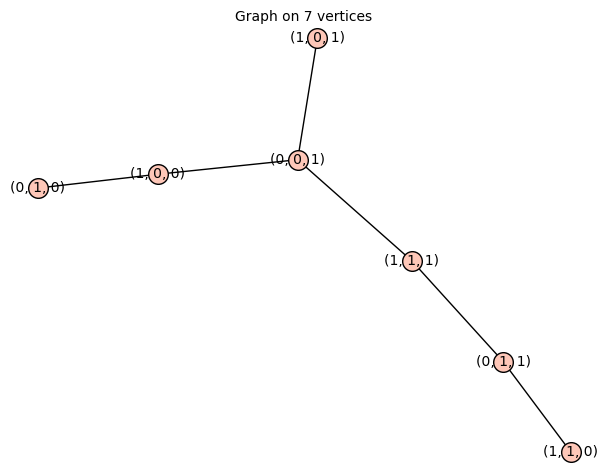

In [150]:
G

In [ ]:
fact_fixed_conj

In [ ]:
def t(n,q):
    return (gaussian_binomial(n,1,q=q))^(n-2)
    

In [ ]:
t(n,q)

In [ ]:
n=4
q=2
nq *sum(gaussian_binomial(n-2,k,q=q)*t(k+1,2)*t(n-k-1,2) for k in range(n-2))

In [ ]:
from sage.combinat.q_analogues import q_catalan_number
q_catalan_number(Integer(2))

In [ ]:
from sage.plot.graphics import GraphicsArray


In [ ]:
#fact = factorization, c = singer
#returns the cyclic orbit
def cyclic_orbit(fact, c):
    cyclic=[]
    while 1:
        f = fact[-1]
        fact.remove(f)
        fact.insert(0,c*f*c^(-1))
        if fact not in cyclic:
            cyclic.append(copy(fact))
        else:
            break
    return cyclic

In [ ]:
for f in fact_g:
    cyc = cyclic_orbit(f,prod(f))
    if len(cyc) == 13:
        thef = f

In [ ]:
for new in newlist:
    for rrr in new:    
        symm=[]
        Mlist =get_adj_matrix(rrr)
        for m in Mlist:
            D= DiGraph(m)
            G=D.to_directed()
            #G.show()
            cycle = G.all_simple_cycles()
            #print(edge)
            tup=[]
            for c in cycle:
                newc=[x+1 for x in c[1:]]
                tup.append(tuple(newc))
            #print(tup)
            refl = GG(tup)
            symm.append(refl)
        print(symm,prod(symm))
    print('skip')

In [ ]:
alledge

In [ ]:
for rrr in fact_g:
    [M1,M2,M3]=get_adj_matrix(rrr)
    Dlist=DiGraph(M1),DiGraph(M2),DiGraph(M3)
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()
    #G.delete_vertices([vertex[0],vertex[1],vertex[4]])
    G.graphplot(color_by_label=True,vertex_size=0,layout='spring').show()
print('skip')

In [ ]:
for rrr in fact_g:    
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_directed()
        #G.show()
        cycle = G.all_simple_cycles()
        #print(edge)
        tup=[]
        for c in cycle:
            newc=[x+1 for x in c[1:]]
            tup.append(tuple(newc))
        #print(tup)
        refl = GG(tup)
        symm.append(refl)
    print(symm,prod(symm))

In [ ]:
str(5)

In [ ]:

for new in newlist:
    for rrr in new:    
        symm=[]
        Mlist =get_adj_matrix(rrr)
        for m in Mlist:
            D= DiGraph(m)
            G=D.to_directed()
            #G.show()
            cycle = G.all_simple_cycles()
            #print(edge)
            tup=[]
            for c in cycle:
                newc=[x+1 for x in c[1:]]
                tup.append(tuple(newc))
            #print(tup)
            refl = GG(tup)
            symm.append(refl)
        print(symm,prod(symm))
    print('skip')

In [ ]:
for new in newlist: 
    for rrr in new:
        [M1,M2,M3]=get_adj_matrix(rrr)
        Dlist=DiGraph(M1),DiGraph(M2),DiGraph(M3)
        alledge=[]
        for i in range(n):
            for u,v,l in Dlist[i].edges():
                Dlist[i].set_edge_label(u,v,str(i))
            alledge = alledge+Dlist[i].edges()
        D=DiGraph()
        D.add_edges(alledge)
        D.relabel(vertex)
        G=D.to_undirected()
        #G.delete_vertices([vertex[0],vertex[1],vertex[4]])
        G.graphplot(color_by_label=True,vertex_size=0,layout='spring').show()
    print('skip')

In [ ]:
def labeled_tree2fact(ep):
    return [(e[0]+1,e[1]+1) for e in ep]

GG=SymmetricGroup(nq)

In [ ]:
def is_reflection(g):
    n = G.degree()
    M = g.matrix() - (G[0]^0).matrix()
    KM = M.kernel()
    return KM.dimension() == n-1

def is_transvection(g):
    return is_reflection(g) and M(g).determinant() == 1


def get_transvections(): #find all transvection in a list
    R = []
    for g in G:
        if is_transvection(g):
            R.append(g)
    return R

def get_refls(): #find all reflections in a list
    R = []
    for g in G:
        if is_reflection(g):
            R.append(g)
    return R
def get_fact(R,c):#given a list of reflections and a singer cycle returns the list of factorization in reflections
    F = []
    for i in product(range(len(R)),repeat = G.degree()):
        if mul([R[i[k]] for k in range(G.degree())]) == c:
            F.append([R[i[k]] for k in range(G.degree())])
    return F

In [ ]:
R=get_refls()
fact1=get_fact(R,sing[0])

In [ ]:
len(fact1)

In [ ]:
#for new in fact_g:
    #print('space')
for rrr in fact1:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge)
        symm.append(refl)
    print(symm,prod(symm))

In [ ]:
vertex

In [ ]:
#for new in fact_g:
    #print('space')
for rrr in fact_g:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge[1:4])
        symm.append(refl)
    print(symm,prod(symm))

In [ ]:
fact_g[1],prod(fact_g[1])

In [ ]:
#for new in fact_g:
    #print('space')
for rrr in fact_g:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge)
        symm.append(refl)
    print(symm,prod(symm))